<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split , cross_val_score ,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
house = pd.read_csv('./housing.csv')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
#C (all) is non residential
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
#drop all non-residential entries
drop_list = list(house[house['MSZoning']=="C (all)"].index)
house.drop(index = drop_list,inplace = True)

In [6]:
#create new feature age_sold before removing the columns
house['age_sold'] = house['YrSold']-house['YearRemodAdd']

In [7]:
#drop columns that is not a characteristic of house
not_house_char = ['Id','MoSold','YearBuilt','YearRemodAdd','SaleType','GarageYrBlt']
house.drop(columns =(not_house_char) , inplace = True)


In [8]:
#split 'fixed' and 'not fixed' variables.

fixed_var = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape',
             'LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
             'Condition2','BldgType','HouseStyle','RoofStyle','MasVnrArea','Foundation',
             'BsmtExposure','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
             'Fireplaces','GarageType','GarageCars','GarageArea','PavedDrive','WoodDeckSF',
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscFeature','MiscVal','SaleCondition','SalePrice','YrSold','age_sold']
not_fixed = [i for i in house.columns if i not in fixed_var]

#columns that will be used to train Q1 model.
house_fixed = house[fixed_var]

#set aside columns 
house_renov = house[not_fixed]


In [9]:
house_fixed.isnull().sum().sort_values(ascending= False).head(10)

MiscFeature     1398
Alley           1361
LotFrontage      259
GarageType        79
BsmtExposure      38
MasVnrArea         8
age_sold           0
Condition1         0
TotalBsmtSF        0
Foundation         0
dtype: int64

In [10]:
#Fixed the easy null values first. The null values have meanings. 
house_fixed.loc[house_fixed['Alley'].isnull(),"Alley"] = "N"
house_fixed.loc[house_fixed['GarageType'].isnull(),"GarageType"] = "N"
house_fixed.loc[house_fixed['BsmtExposure'].isna(),"BsmtExposure"] = "N"

C:\Users\B6NT\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
house_fixed[house_fixed['MiscFeature'].isnull()]["MiscVal"].value_counts()

0    1398
Name: MiscVal, dtype: int64

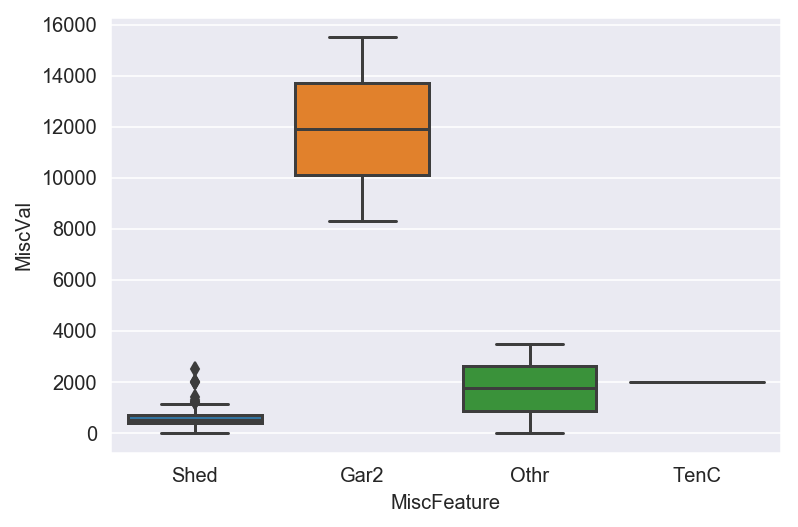

In [12]:
sns.boxplot(x = 'MiscFeature' , y ='MiscVal' , data = house_fixed )

In [13]:
#Decided to drop Misc Feature because "MiscVal" column will be able to represent it.
house_fixed.drop(columns = 'MiscFeature',inplace = True)

C:\Users\B6NT\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


C:\Users\B6NT\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


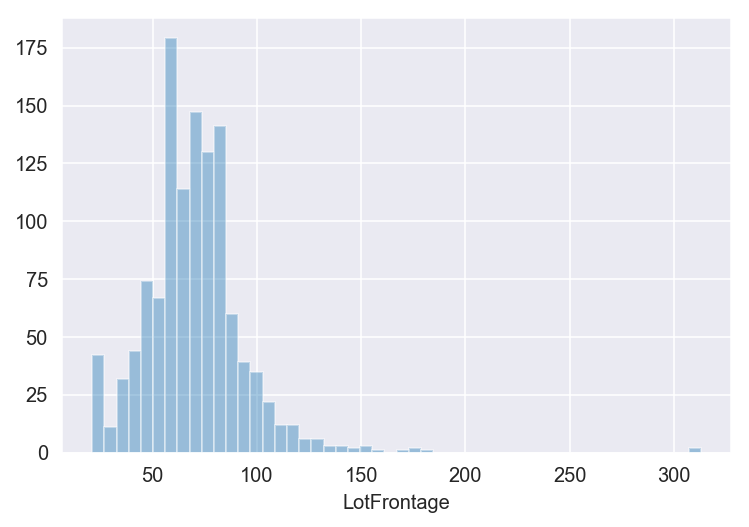

In [14]:
sns.distplot(house_fixed['LotFrontage'].dropna() , kde = False)

In [15]:
#decided to impute null value with mean
frontage_mean = np.mean(house_fixed['LotFrontage'].dropna())
#impute na with mean value
house_fixed.loc[house_fixed['LotFrontage'].isna(),"LotFrontage"] = frontage_mean


In [16]:
#check why MasVnrArea has null. Retrieve columns from main dataframe
house[house['MasVnrArea'].isnull()]['MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [17]:
#MasVnrArea is Null value, because MasVnrType is None, meaning no Masonry Veneer
house_fixed['MasVnrArea'] = house_fixed['MasVnrArea'].replace(np.nan,0)

C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
#'MsSubclass' should be categorical type
house_fixed['MSSubClass'] = house_fixed['MSSubClass'].astype(str)

C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


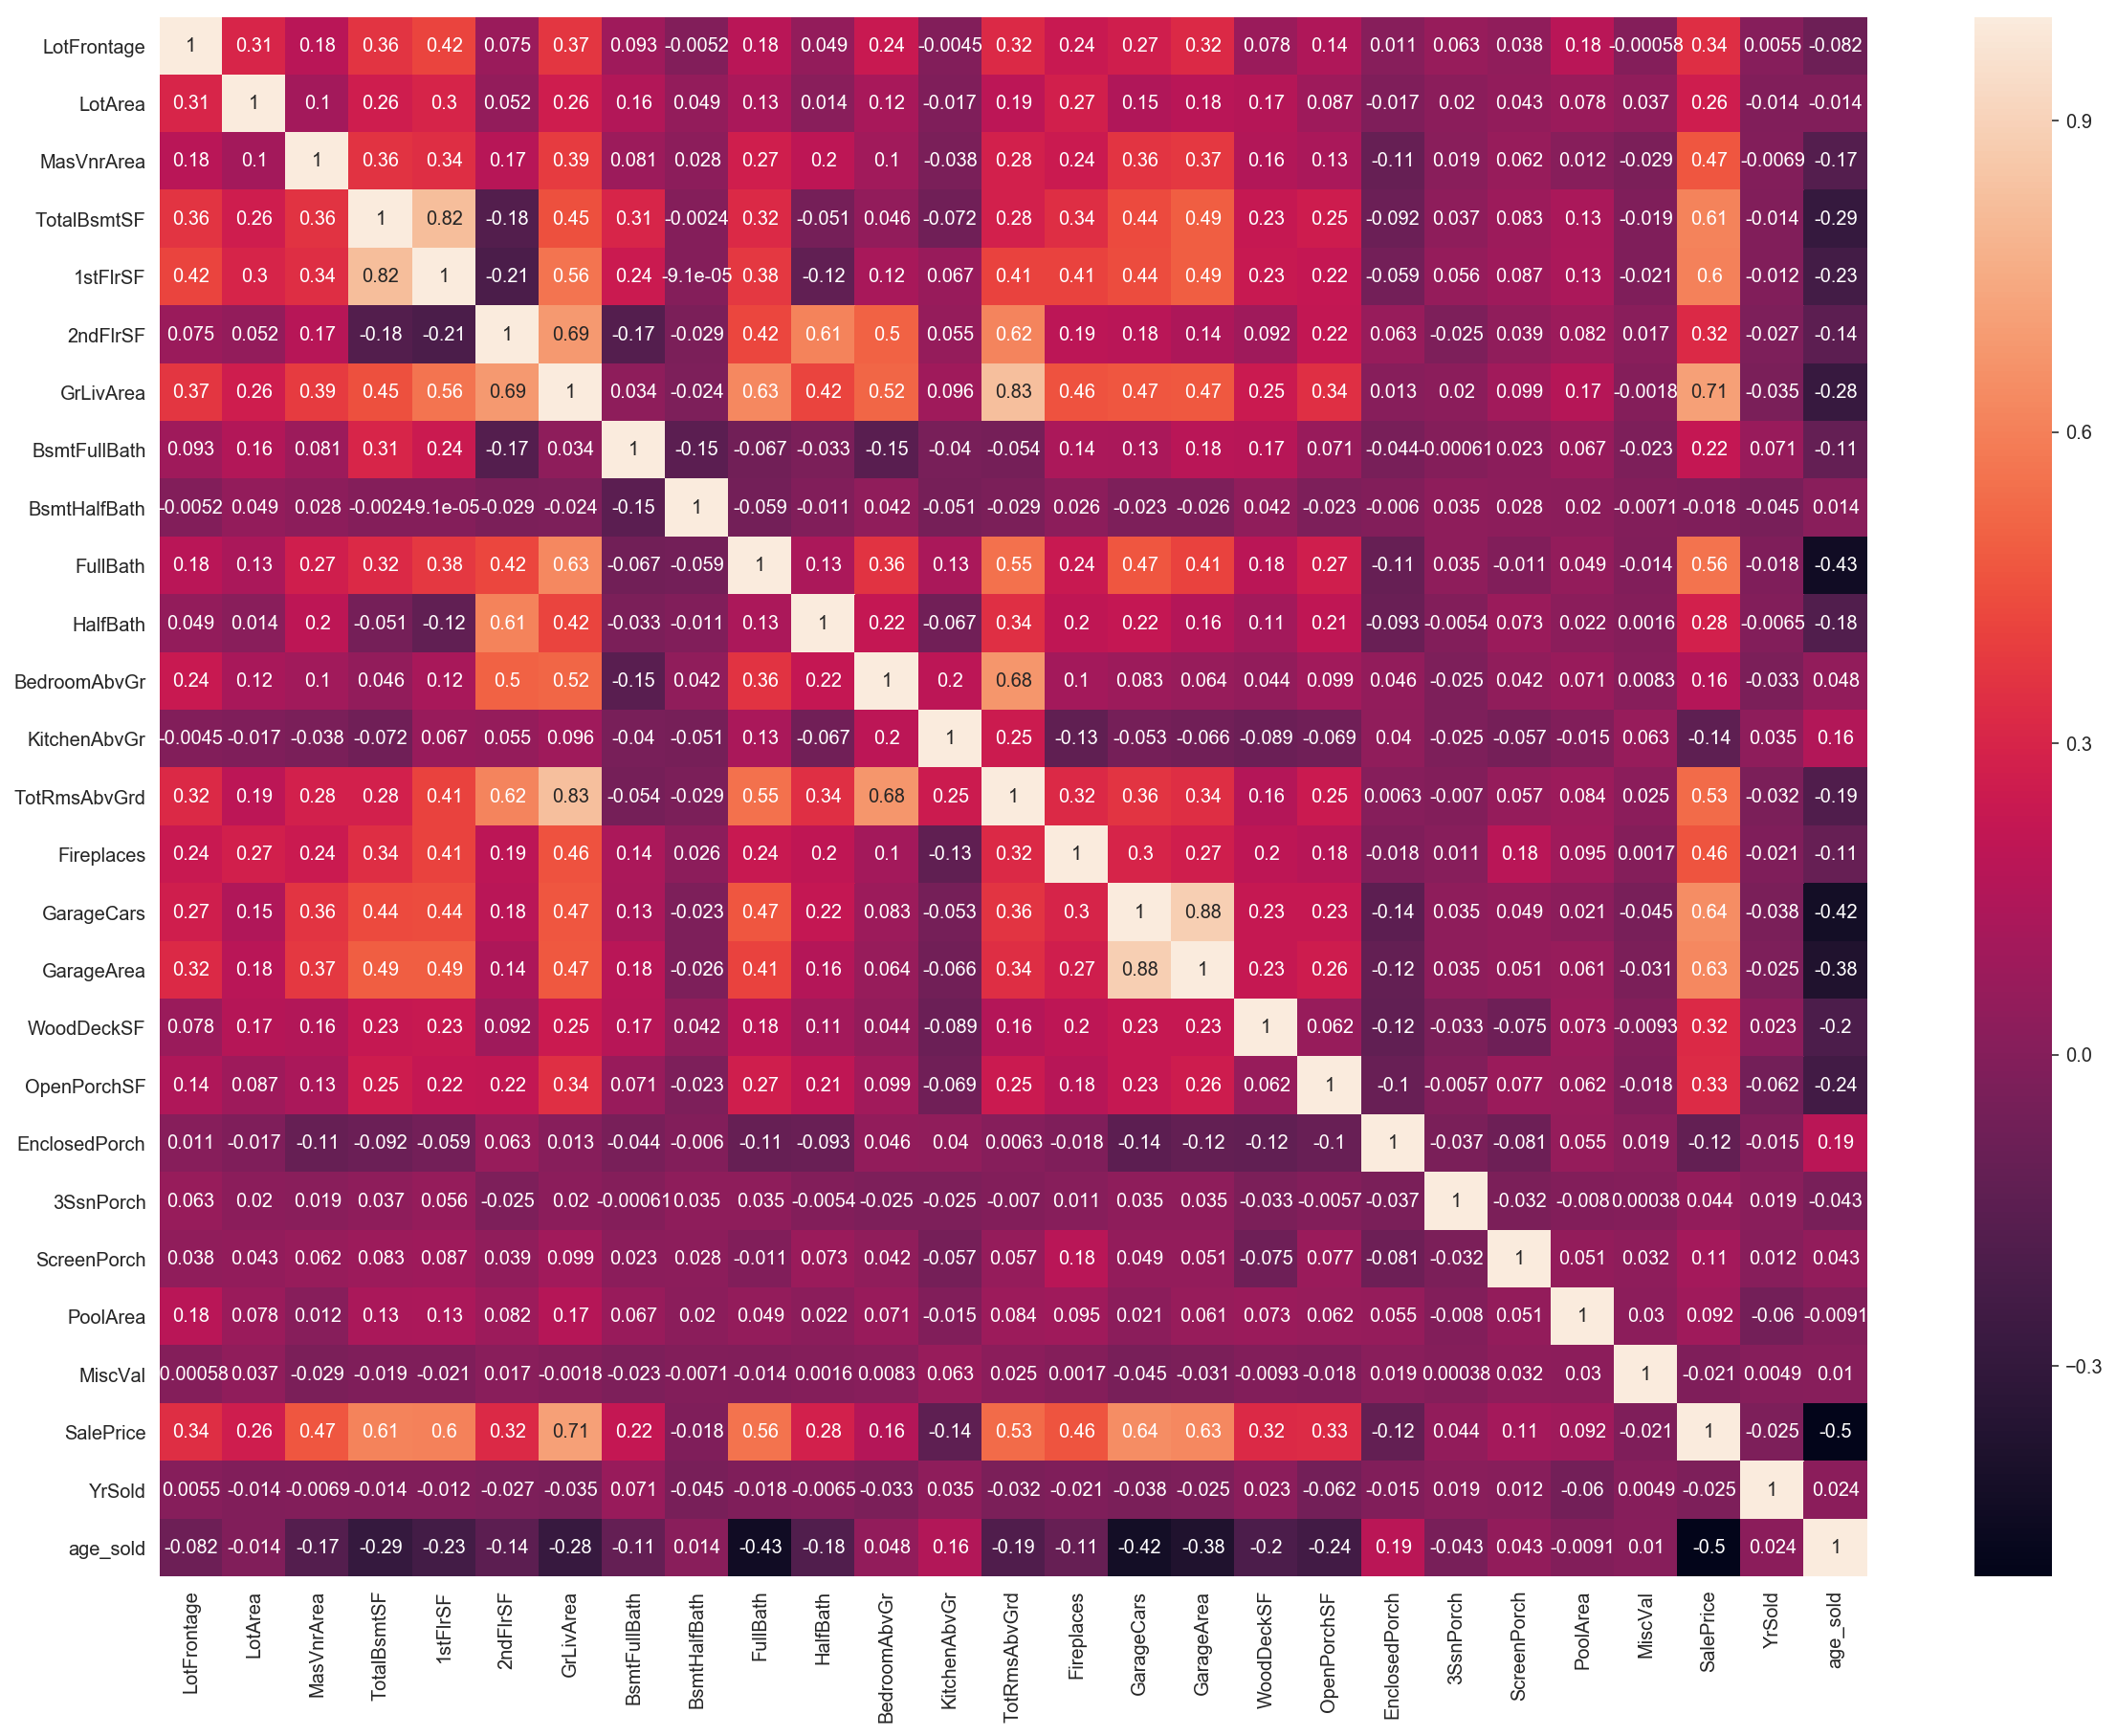

In [19]:
plt.figure(figsize=(20,15))
sns.heatmap(house_fixed.corr() , annot = True)

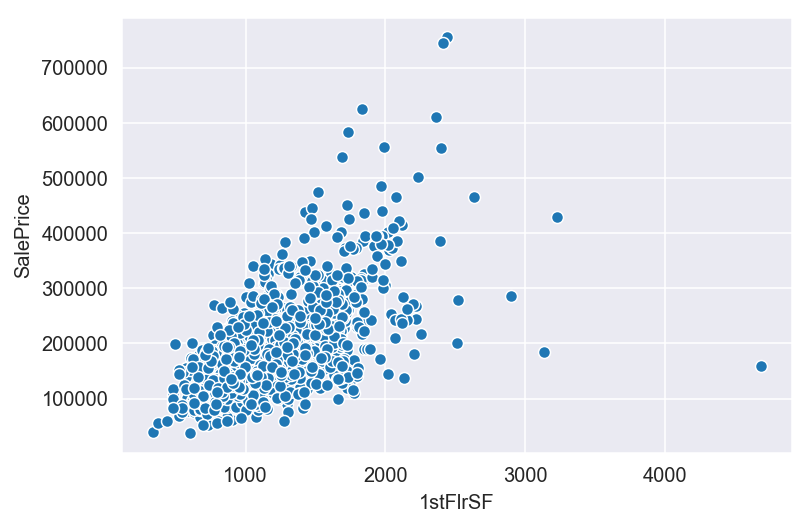

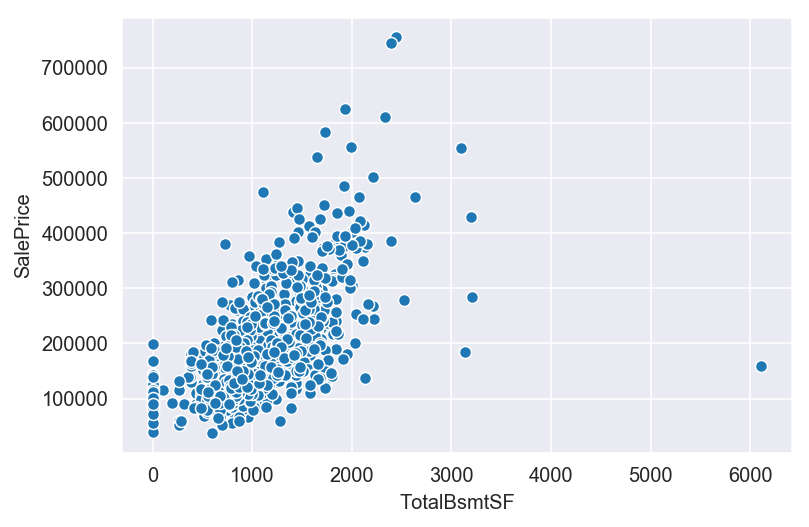

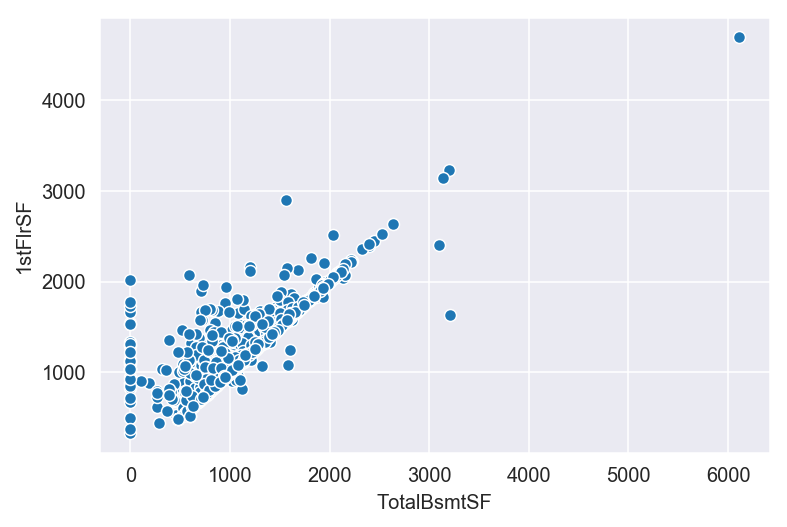

,1stFlrSF,TotalBsmtSF,SalePrice
1stFlrSF,1.000000,0.819138,0.603300
TotalBsmtSF,0.819138,1.000000,0.612088
SalePrice,0.603300,0.612088,1.000000


In [20]:
# look into 1stFlrSF + TotalBsmtSF as they are highly correlated : 0.82
sns.scatterplot(x = '1stFlrSF' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotalBsmtSF' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotalBsmtSF' , y = '1stFlrSF' , data= house_fixed)
plt.show()

house_fixed[['1stFlrSF','TotalBsmtSF','SalePrice']].corr()

In [21]:
#decided to drop 1stFlrSF as TotalBsmtSF has a higher correlation to price. 
house_fixed= house_fixed.drop(columns = '1stFlrSF')

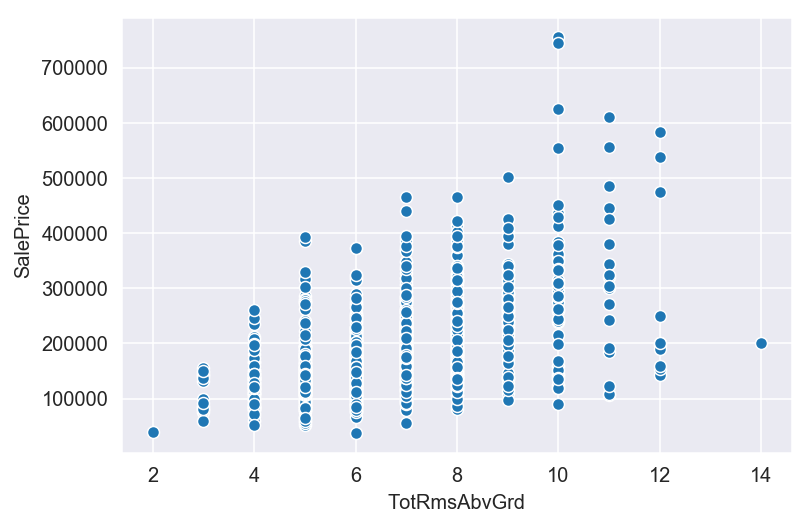

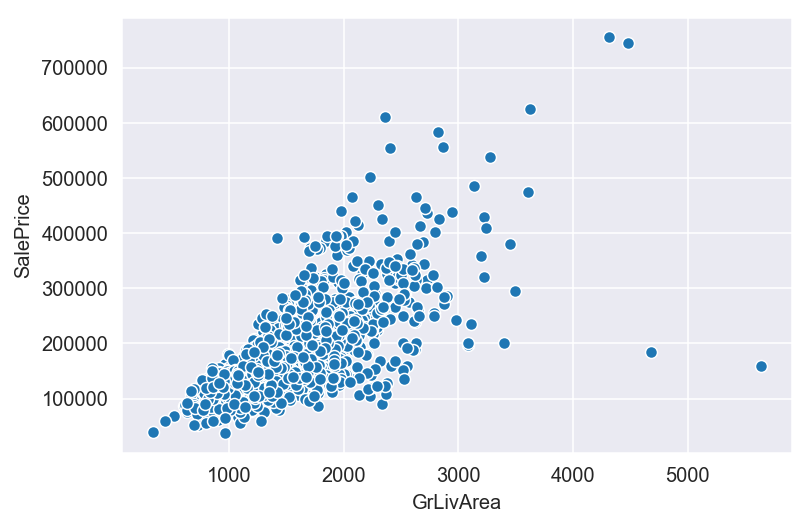

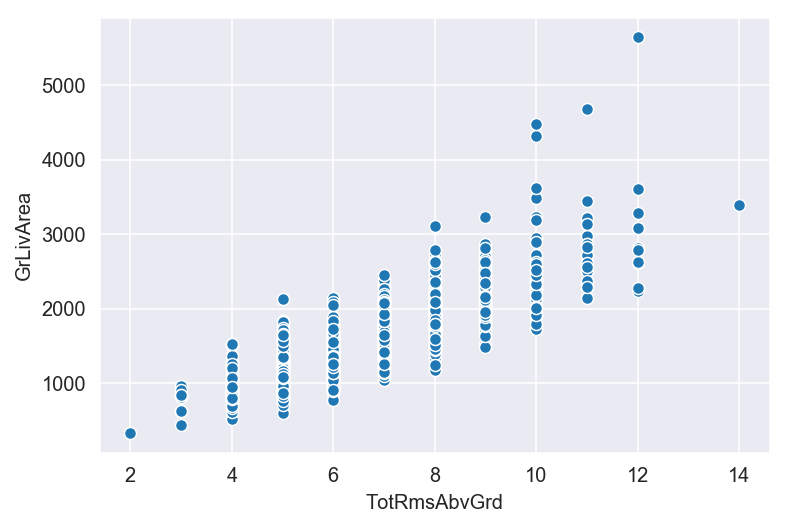

,TotRmsAbvGrd,GrLivArea,SalePrice
TotRmsAbvGrd,1.000000,0.825183,0.533355
GrLivArea,0.825183,1.000000,0.708658
SalePrice,0.533355,0.708658,1.000000


In [22]:
#look into GrLivArea + totalroomsabvgrd as they are highly correlated : 0.83 

sns.scatterplot(x = 'TotRmsAbvGrd' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GrLivArea' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'TotRmsAbvGrd' , y = 'GrLivArea' , data= house_fixed)
plt.show()

house_fixed[['TotRmsAbvGrd','GrLivArea','SalePrice']].corr()

In [23]:
#decided to drop TotRmsAbvGrd as GrLivArea has higher correlation to SalePrice
house_fixed= house_fixed.drop(columns = 'TotRmsAbvGrd')

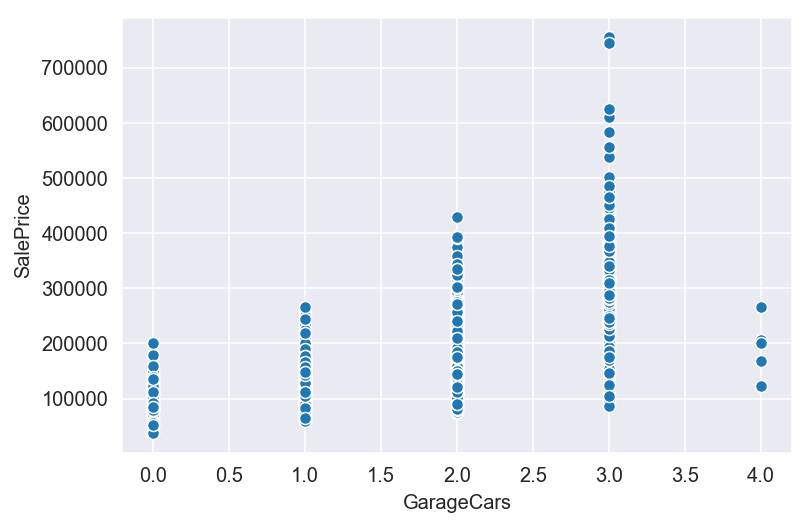

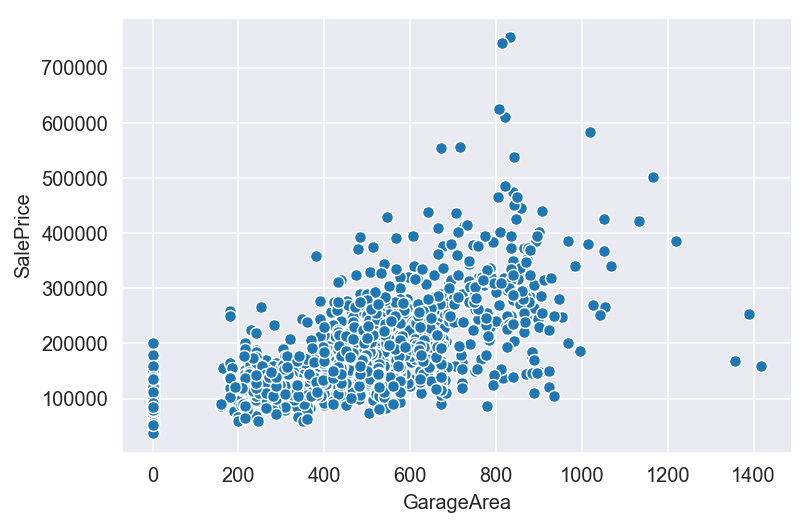

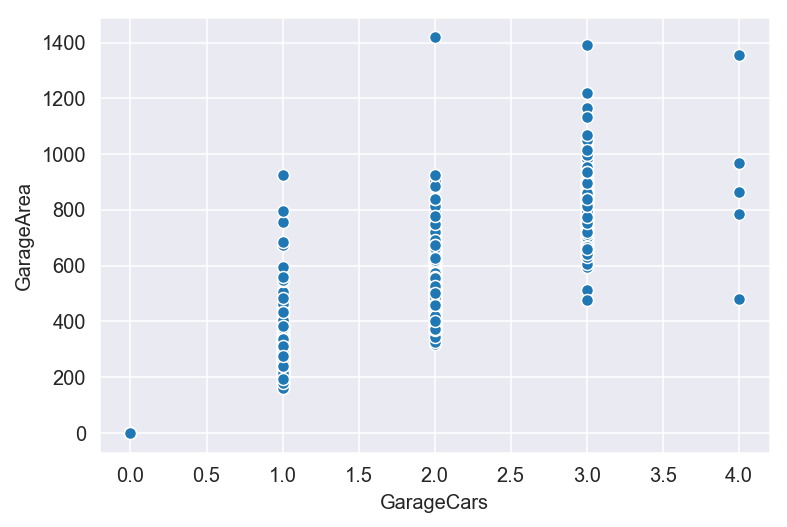

,GarageCars,GarageArea,SalePrice
GarageCars,1.000000,0.883009,0.642135
GarageArea,0.883009,1.000000,0.629831
SalePrice,0.642135,0.629831,1.000000


In [24]:
#look into GarageCars + GarageArea as they are highly correlated : 0.88

sns.scatterplot(x = 'GarageCars' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GarageArea' , y = 'SalePrice' , data= house_fixed)
plt.show()

sns.scatterplot(x = 'GarageCars' , y = 'GarageArea' , data= house_fixed)
plt.show()

house_fixed[['GarageCars','GarageArea','SalePrice']].corr()

In [25]:
#decided to drop GarageArea as GarageCars has higher correlation to SalePrice
house_fixed= house_fixed.drop(columns = 'GarageArea')

In [26]:
#get a list of all object column and apply get_dummies
categorical = list(house_fixed.select_dtypes(include=['object']).columns)
df_dummies = pd.get_dummies(house_fixed[categorical], drop_first=True)

In [27]:
house_fixed= house_fixed.drop(columns = categorical)

In [28]:
house_fixed = pd.concat([house_fixed, df_dummies], axis=1)

In [29]:
len(house_fixed.columns)

134

In [30]:
house_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 134 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int64(22), uint8(110)
memory usage: 479.0 KB


In [31]:
#split data into 2010(test data) and before 2010(training data)
house_fixed_2010 = house_fixed[house_fixed['YrSold'] == 2010]
y_test = house_fixed_2010[['SalePrice']]
X_test = house_fixed_2010.drop(columns = 'SalePrice')

house_fixed_training = house_fixed[house_fixed['YrSold'] < 2010]
y_train = house_fixed_training[['SalePrice']]
X_train = house_fixed_training.drop(columns = 'SalePrice')

In [32]:
#perform automatic feature selection method "SelectKBest"
from sklearn.feature_selection import SelectKBest,f_regression
cols = list(X_train.columns)
# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression)

# Train the selector on the data.
skb_f.fit(X_train, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_),list(skb_f.pvalues_)], 
                     index=['feature','f_regression','p_values']).T.sort_values\
                     ('f_regression', ascending=False)

#select only variables with p-value lower than 0.05
significant = kbest[kbest['p_values']<0.05]
significant


C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,feature,f_regression,p_values
5,GrLivArea,1284,3.75489e-195
13,GarageCars,894.937,1.96186e-149
3,TotalBsmtSF,731.737,9.40283e-128
8,FullBath,590.937,1.41251e-107
22,age_sold,443.142,1.11217e-84
112,Foundation_PConc,387.207,1.71151e-75
12,Fireplaces,358.346,1.24868e-70
2,MasVnrArea,353.786,7.46263e-70
71,Neighborhood_NridgHt,255.633,1.38069e-52
31,MSSubClass_60,221.62,2.44548e-46


In [33]:
#Select range of features by 10 by f_regression score
top_list=[]
for i in range(10,100,10):
    top =[]
    top = list(significant.feature.head(i))
    top_list.append(top)
top_list

[['GrLivArea',
  'GarageCars',
  'TotalBsmtSF',
  'FullBath',
  'age_sold',
  'Foundation_PConc',
  'Fireplaces',
  'MasVnrArea',
  'Neighborhood_NridgHt',
  'MSSubClass_60'],
 ['GrLivArea',
  'GarageCars',
  'TotalBsmtSF',
  'FullBath',
  'age_sold',
  'Foundation_PConc',
  'Fireplaces',
  'MasVnrArea',
  'Neighborhood_NridgHt',
  'MSSubClass_60',
  'GarageType_Detchd',
  'SaleCondition_Partial',
  'LotFrontage',
  'Neighborhood_NoRidge',
  'OpenPorchSF',
  'WoodDeckSF',
  'GarageType_Attchd',
  'Foundation_CBlock',
  '2ndFlrSF',
  'BsmtExposure_Gd'],
 ['GrLivArea',
  'GarageCars',
  'TotalBsmtSF',
  'FullBath',
  'age_sold',
  'Foundation_PConc',
  'Fireplaces',
  'MasVnrArea',
  'Neighborhood_NridgHt',
  'MSSubClass_60',
  'GarageType_Detchd',
  'SaleCondition_Partial',
  'LotFrontage',
  'Neighborhood_NoRidge',
  'OpenPorchSF',
  'WoodDeckSF',
  'GarageType_Attchd',
  'Foundation_CBlock',
  '2ndFlrSF',
  'BsmtExposure_Gd',
  'MSZoning_RM',
  'HalfBath',
  'BsmtExposure_No',
  'LotS

In [34]:
#Apply linear regression model on the features selected by using kbest_f_regression
#Run through different number of features. 
for ls in top_list:
    print("===",len(ls), "Features===")
#     Xs = ss.fit_transform(X_train[ls])
#     Xs_test = ss.transform(X_test[ls])
    X_ = X_train[ls]
    X_test_ = X_test[ls]
    model = LinearRegression()
    # Perform cross-validation
    scores = cross_val_score(model,X_, y_train, cv=10)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

    model.fit(X_,y_train)

    print("Test Score:" ,model.score(X_test_,y_test))
    print("")

=== 10 Features===
Cross-validated scores: [0.78234934 0.81160027 0.83572281 0.70820872 0.74963205 0.82212446
 0.79301186 0.73779453 0.43250456 0.79490364]
Mean CV R2: 0.7467852243594358
Std CV R2: 0.11128943981405656
Test Score: 0.7953860676269613

=== 20 Features===
Cross-validated scores: [0.82117761 0.80825484 0.82145657 0.72171282 0.79243563 0.8367651
 0.79373702 0.73739171 0.47773964 0.83189097]
Mean CV R2: 0.7642561899802489
Std CV R2: 0.10225771044451039
Test Score: 0.8004075732657526

=== 30 Features===
Cross-validated scores: [0.83425051 0.81593887 0.8267054  0.73478309 0.79480633 0.83600745
 0.80246247 0.75260446 0.50393911 0.83364472]
Mean CV R2: 0.7735142404051227
Std CV R2: 0.09578023879075001
Test Score: 0.815645879414789

=== 40 Features===
Cross-validated scores: [0.85623547 0.8489882  0.85515726 0.75721019 0.79694225 0.82431971
 0.80943294 0.78005074 0.51203177 0.84152268]
Mean CV R2: 0.7881891200341671
Std CV R2: 0.09735408619313453
Test Score: 0.8416542960193013

==

Achieved the best score when 82 features use being applied. 

Linear Regression ( No standard Scaler ) 

=== 82 Features===

Cross-validated scores: [0.87380544 0.86701797 0.85377617 0.76242801 0.81117823 0.83643771
 0.84168206 0.79725491 0.56438568 0.84422009]
 
Mean CV R2: 0.8052186276395815

Std CV R2: 0.08639268118989062

Test Score: 0.8538286127527391

Next step

Try to scale features to see if its possible to get a better result.

In [37]:
#Apply linear regression model on the features selected by using kbest_f_regression
#Run through different number of features.

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

print("===",len(top_list[-1]), "Features===")
Xs_train = ss.fit_transform(X_train[top_list[-1]])
Xs_test = ss.transform(X_test[top_list[-1]])
model = LinearRegression()
# Perform cross-validation
scores = cross_val_score(model,Xs_train, y_train, cv=10)
print("Cross-validated scores:", scores)
print("Mean CV R2:", np.mean(scores))
print('Std CV R2:', np.std(scores))

model.fit(Xs_train,y_train)

print("Test Score:" ,model.score(Xs_test,y_test))
print("")

=== 82 Features===
Cross-validated scores: [ 8.71289610e-01  8.66902664e-01  8.53831244e-01  7.62502067e-01
  8.11178232e-01 -2.54048582e+21  8.41464752e-01  7.97289860e-01
  5.65015923e-01  8.44200620e-01]
Mean CV R2: -2.5404858197999652e+20
Std CV R2: 7.621457459399897e+20
Test Score: 0.853830283608971



C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


After scaling , the mean cv R2 becomes abnormal. 

Next step , try fitting into LassoCv to see if we could reduce the number of variables further. 

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Lasso
#find optimal alpha from lassocv
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)
print(optimal_lasso.alpha_)

In [ ]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)
lasso.fit(Xs_train,y_train)
lasso.score(Xs_test,y_test)

print("===Lasso(85 Features)===")
print("Cross-validated scores:", lasso_scores)
print("Mean CV R2:", np.mean(lasso_scores))
print('Std CV R2:', np.std(lasso_scores))
print("Test Score:" ,lasso.score(Xs_test,y_test))

lasso_coefs = pd.DataFrame({'variable':X_train[top_85].columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('coef', inplace=True, ascending=False)

lasso_coefs[lasso_coefs['coef']!=0].sort_values(by='abs_coef', ascending = False)

In [ ]:
testing = house_fixed[list(lasso_coefs[lasso_coefs['coef']!=0].sort_values(by='variable', ascending = False)['variable'])]

Linear Regression ( No Standard Scaler )

=== Linear Regression(85 Features)===

Mean CV R2: 0.8043726302363117

Std CV R2: 0.0880676789316058

Test Score: 0.85977563254309643

 
===Lasso(85 Features)=== After Lasso , left with 62 variables. 

Mean CV R2: 0.8115648594414762

Std CV R2: 0.0906442588704613

Test Score: 0.8583730309107461    
    
Decided that Lasso was the better model, as it has similar performance with lesser dimension.

In [ ]:
top_10 = lasso_coefs[lasso_coefs['coef']!=0].sort_values(by='abs_coef', ascending = False).head(10)
top_10.sort_values(by = 'abs_coef', ascending = False)

Above table shows the top 10 features that is best at estimating the sales price.

1) Every 1 std-deviation unit increase of GrLivArea will increase the sales price by about $25,000.

2)The neighborhood where the apartment also plays a big role.

Highest to lowest price :Northridge Heights, Northridge , Stone Brook ,Somerset

3) Every 1 std-deviation unit increase of "Size of garage in car capacity" will increase the sales price by about $25,000.

4) Every 1 std-deviation unit of age the apartment is sold, will decrease the price of the house by about $7100

5) Having too many kitchen will affect the price of the sale negatively. 

6) Every 1 std-deviation unit of basement square feet will increase the price of the house by about $5900.

7) Having a Basement with good exposure also increases the sale price by about $5,700





<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: